# Domain Sorting 
## Author: Damien 

For this implementation, of domain sorting, we assume that the domain and all sub-domains are hyperrectangles.

In [10]:
import numpy as np
from anytree import NodeMixin, RenderTree
import math
import matplotlib.pyplot as plt

In [2]:
class MFDomain(NodeMixin):
    def __init__(self,vertices,parent=None,children=None):
        super(MFDomain,self).__init__()
        self.vertices = np.array(vertices) # two opposite vertices that define the n-dimensional box
        self.parent = parent

        if children: # set children
            self.children = children

        self.root.tree_level_organizer(self)

    def weight(self,x):
        """
        This is the coefficient weight function of the neural domain
        # NOTE: This function only currently works for 1D functions. I need to implement a high dimensional version
        """
        vertices = self.vertices
        mu = (vertices[0] + vertices[1])/2
        sigma = (vertices[1] - vertices[0])/2
        w = 1+ np.cos(math.pi*(x-mu)/sigma)
        w = w**2
        return w

    def apply_mf(self,pts,u_lf):
        val = np.ones(len(pts))
        return val


In [6]:
class RootUtilities:
    def __init__(self):
        self.levels = [] # list of what classes are on which levels of the domain tree

    def tree_level_organizer(self,new_node):
        """
        This function recognizes which level "new_node" is on and places the class in the appropriate
        level in "self.levels".
        """
        depth = new_node.depth # find the depth of the new node
        if depth >= len(self.levels): # if "new_node" is the first on a new level, add that level to "self.levels"
            self.levels.append([new_node])
        else: # if "new_node" is a member of an existing level, add it to that level of "self.levels"
            self.levels[depth].append(new_node)

class SFDomain(RootUtilities,NodeMixin):
    def __init__(self,vertices,children=None):
        super(SFDomain,self).__init__()
        self.vertices = np.array(vertices) # two opposite vertices that define the n-dimensional box

        if children: # set children
            self.children = children

        self.pts = np.array([]) # the points on the interior of the root domain
        self.global_indices = np.arange(1) # NOTE: This is a hard-coded batch size. This needs to be changed.

        self.tree_level_organizer(self)
    
    def apply_sf(self,pts): # dummy function to test "evaluate_neural_domain_tree"
        val = np.ones(len(pts))
        return val

    def find_interior_points(self,verts,parent_pts): # TESTED
        """
        Creates a mask that communicates the locations of which points in "pts" are in the hyperrectangle
        defined by verts.
        """
        indices = []
        pts = []
        number_of_points = len(parent_pts)
        for i in range(number_of_points):
            condition = ((verts[0] < parent_pts[i]) & (parent_pts[i] < verts[1])).all()
            if condition:
                indices.append(i)
                pts.append(parent_pts[i])
        return np.array(indices), np.array(pts)

    def evaluate_neural_domain_tree(self,pts): # TESTED
        """
        Evaluate the neural domain tree layer by layer. 
        NOTE: The current code only works if the support of the union of the domains at each level is the original domain.
        """
        self.pts = pts # save points to class
        u_pred = self.apply_sf(pts)
        u_preds = np.zeros((len(self.levels),len(pts)))
        u_preds[0,:] = u_pred # the first prediction of the solution is the single fidelity net
        self.global_indices = np.arange(len(pts)) # NOTE: This is inefficient. Find a better way to set this
        iter = 1
        for level in self.levels[1:]: # iterates through the levels of the domain tree (skipping the first level which contains the root)
            u_pred = np.zeros(len(pts))
            for mfdomain in level: # iterates through the MFDomains in each level of the tree. NOTE: parallelize this loop
                parent = mfdomain.parent        
                local_indices, mfdomain.pts = self.find_interior_points(mfdomain.vertices,parent.pts)
                mfdomain.global_indices = parent.global_indices[local_indices] # get the indices of the points in the support of mfdomain
                output = mfdomain.apply_mf(mfdomain.pts,u_preds[-1][mfdomain.global_indices]) # analyze the local network
                u_pred[mfdomain.global_indices] += output # add the output to the prediction of the solution
            u_preds[iter,:] = u_pred
            iter += 1
        return u_preds

### Testing the "evaluate_neural_domain_tree" function

In [7]:
A = SFDomain([[0.0],[1.0]])
B = MFDomain([[0.0],[0.6]],parent = A)
C = MFDomain([[0.4],[1.0]],parent = A)
D = MFDomain([[0.0],[0.3]],parent = B)
E = MFDomain([[0.2],[0.5]],parent = B)
F = MFDomain([[0.4],[0.7]],parent = C)
G = MFDomain([[0.6],[1.0]],parent = C)

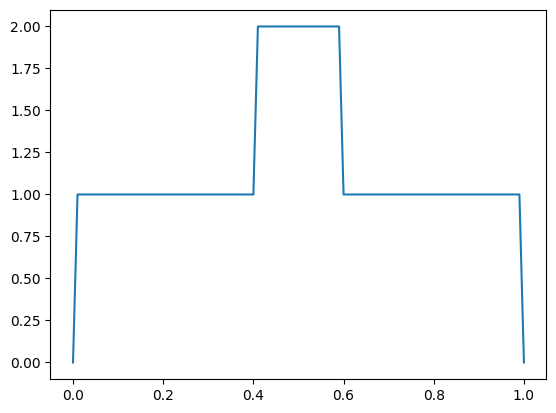

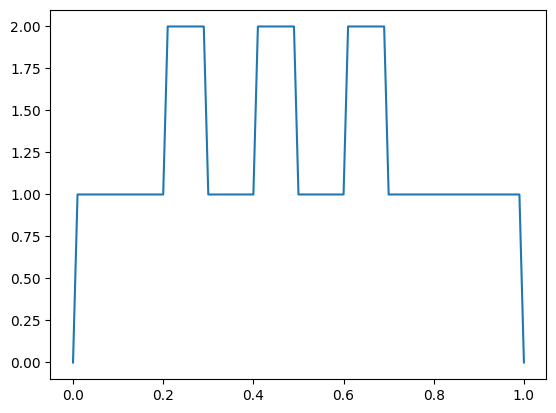

In [15]:
pts = np.linspace(0,1,101)
pts = pts.reshape(-1,1)
u_preds = A.evaluate_neural_domain_tree(pts)
plt.plot(pts,u_preds[1,:])
plt.show()
plt.plot(pts,u_preds[-1,:])
plt.show()

In [32]:
((np.array([0.6]) <= np.array([0.6])) & (True)).all()

False

### Testing the "find_interior_pts" function

In [20]:
A = SFDomain([[0.],[1.]])
B = MFDomain([[0.5],[1.]],parent = A)
C = MFDomain([[0.],[0.5]],parent = A)
D = MFDomain([[0.75],[1.]],parent = B)
E = MFDomain([[0.5],[0.75]],parent = B)

In [22]:
# 2D example
pts = np.array([[0.2,0.6],[0.6,1.0],[1.0,1.0],[5.0,0.4],[-0.8,-0.8],[0.0,0.0]])
verts = np.array([[0.0,0.0],[1.0,1.0]])
A.find_interior_points(verts,pts)

(array([0, 1, 2, 5]),
 array([[0.2, 0.6],
        [0.6, 1. ],
        [1. , 1. ],
        [0. , 0. ]]))

In [19]:
# 1D example
pts = np.array([[0.2],[0.6],[0.3],[0.7],[0.9],[0.4],[0.8]])
verts = np.array([[0.3],[0.7]])
A.find_interior_points(verts,pts)

(array([1, 2, 3, 5]),
 array([[0.6],
        [0.3],
        [0.7],
        [0.4]]))

### Showing that the code can take the nodes added to the tree and place them in the array list

In [20]:
# A = SFDomain([0.,1.])
# B = MFDomain([0.5,1.],parent = A)
# C = MFDomain([0.,0.5],parent = A)
# D = MFDomain([0.75,1.],parent = B)
# E = MFDomain([0.5,0.75],parent = B)
A = SFDomain([[0.],[1.]])
B = MFDomain([[0.5],[1.]],parent = A)
C = MFDomain([[0.],[0.5]],parent = A)
D = MFDomain([[0.75],[1.]],parent = B)
E = MFDomain([[0.5],[0.75]],parent = B)

In [21]:
print(RenderTree(A))

├── <__main__.MFDomain object at 0x000002E6E406FE10>
│   ├── <__main__.MFDomain object at 0x000002E6E4C2B8D0>
│   └── <__main__.MFDomain object at 0x000002E6E4C2BF10>
└── <__main__.MFDomain object at 0x000002E6E4C544D0>


In [22]:
A.levels

[[<__main__.SFDomain at 0x2e6e383ba90>],
 [<__main__.MFDomain at 0x2e6e406fe10>, <__main__.MFDomain at 0x2e6e4c544d0>],
 [<__main__.MFDomain at 0x2e6e4c2b8d0>, <__main__.MFDomain at 0x2e6e4c2bf10>]]

### Testing how to use vmap in jax


In [36]:
from jax import vmap
import jax.numpy as jnp
# import numpy as np

In [37]:
def foo(W,x):
    v = jnp.dot(x,W)
    return v

In [46]:
vmap(foo,(0,0))(jnp.array([[1,2],[3,4],[5,6]]),jnp.array([1,2,3]))

Array([[ 1,  2],
       [ 6,  8],
       [15, 18]], dtype=int32)

In [49]:
a = [1, 2, 3, 4]
b = [5, 6, 7]

# Attempting to zip two iterables of different lengths
result = zip(a, b)


In [51]:
result[0]

TypeError: 'zip' object is not subscriptable

In [61]:
v = np.arange(10)
print(v)
print(v[1:-1])

[0 1 2 3 4 5 6 7 8 9]
[1 2 3 4 5 6 7 8]


In [8]:
import jax.numpy as jnp
v = jnp.array([jnp.arange(9)])
jnp.append(v,v,axis=0)


Array([[0, 1, 2, 3, 4, 5, 6, 7, 8],
       [0, 1, 2, 3, 4, 5, 6, 7, 8]], dtype=int32)

In [9]:
import jax.numpy as jnp
v = [jnp.arange(9)]
x = jnp.arange(9)
v.append(x)

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [5]:
def ode(s,t):
    ds = np.array([s[1], -0.05*s[1] - 9.81*np.sin(s[0])])
    return ds

s0 = np.array([1.,1.])
t = np.linspace(0,1,101)

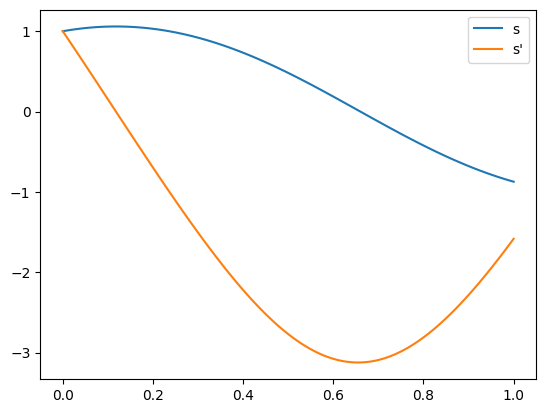

In [11]:
s = odeint(ode,s0,t)
plt.plot(t,s,label=["s","s'"])
plt.legend()
plt.show()